In [1]:
!pip install wfdb

     |████████████████████████████████| 122kB 5.9MB/s 


## Download data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/ /content/gdrive/

In [4]:
!ls

gdrive	sample_data


In [5]:
%cd gdrive/

/content/gdrive


In [6]:
import os

In [7]:
data_path='/content/gdrive/My Drive/physionet.org/files/ptbdb/1.0.0'

In [8]:
import numpy as np

## discover the data

<class 'wfdb.io.record.Record'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adjust_datetime', '_arrange_fields', 'adc', 'adc_gain', 'adc_res', 'adc_zero', 'base_counter', 'base_date', 'base_time', 'baseline', 'block_size', 'byte_offset', 'calc_adc_params', 'calc_checksum', 'check_field', 'check_field_cohesion', 'check_read_inputs', 'check_sig_cohesion', 'checksum', 'comments', 'convert_dtype', 'counter_freq', 'd_signal', 'dac', 'e_d_signal', 'e_p_signal', 'file_name', 'fmt', 'fs', 'get_write_fields', 'get_write_subset', 'init_value', 'n_sig', 'p_signal', 'record_name', 'samps_per_frame', 'set_d_features', 'set_default', 'set_defaults', 'set_p_features', 'sig_len', 'sig_name', 'skew', 'smo

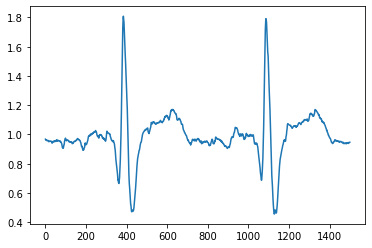

In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
# plot ECG
def draw_ecg(x):
    plt.plot(x)
    plt.show()

#  read_ecg_data
def read_ecg_data(file_path,channel_names,sampfrom=0,smpto=1500):
    '''
    to read the ECG data
    sampfrom: start point，default sampfrom=0
    sampto：end poit，default to the end of data
    channel_names： chanel names which is a list，eg. channel_names=['vx']
    channels：a list with numbers，eg. channels=[0, 3]
    :return: record of ECG
    '''      
    record = wfdb.rdrecord(file_path, sampfrom=0, sampto = 1500 ,channel_names=['vz'])
    print(type(record))

    print(dir(record))
    
    print(record.p_signal)
    print(np.shape(record.p_signal))
    print(record.sig_len)
  
    print(record.record_name)
   
    print(record.n_sig)
   
    print(record.sig_name)
   
    print(record.fs)


    print("***************")
      

    
    print(wfdb.show_ann_labels())

    draw_ecg(record.p_signal)
    return record


#test function
test_file=data_path+'/patient001/s0014lre'
read_ecg_data(test_file,'vx')

# read all data to pd dataframe

In [10]:
import os
import wfdb
import pandas as pd
import pywt
def denoise(data):
    # wavedec
    coeffs = pywt.wavedec(data=data, wavelet='db8', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # threshold
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    rdata = pywt.waverec(coeffs=coeffs, wavelet='db8')
    return rdata
data_path='/content/gdrive/My Drive/physionet.org/files/ptbdb/1.0.0'

def read_data_files(data_path, label_1, sampfrom, sampto):
  
  path_names=os.listdir(data_path)
 # for name in path_names:
  #  if not os.path.isdir(name):
#      path_names.remove(name) 
  i=0
  records = []      
  labels = []           
  for patient_path in path_names:
      PATH=os.path.join(data_path,patient_path)   #path
      #if not os.path.isfile(PATH):
      FILES=os.listdir(PATH)
         #print(FILES) 
        # data_files=[]             
      for file in FILES:
        if '.hea' in file:
              #print(file)
              # data_files.append(file)
            
          record_path=os.path.join(PATH,file.split('.')[0])
          record= wfdb.rdrecord(record_path, sampfrom=sampfrom, sampto = sampto)
          label = record.comments[4].split(':')[1]

          if  label == label_1:
            label = 1
          else:
            label = 0
          #print(label,file)  
          sig_data = record.p_signal.T
          for single_sig in sig_data:
            sigle_sig = denoise(single_sig)
          records.append(sig_data)
          labels.append(label)
  df = pd.DataFrame(columns=['data','label'])
  df['data'] = records
  df['label'] = labels
  return df         

sampfrom=0
sampto = 30000
#all_records=read_data_files(data_path)
df = read_data_files(data_path,' Myocardial infarction',sampfrom, sampto)


In [11]:
df.shape

(549, 2)

In [12]:
df.head()

,data,label
0,"[[-0.2445, -0.2425, -0.2415, -0.241, -0.2315, ...",1
1,"[[-0.474, -0.444, -0.4555, -0.462, -0.459, -0....",1
2,"[[0.254, 0.263, 0.2755, 0.28, 0.3035, 0.305, 0...",1
3,"[[0.2735, 0.287, 0.2925, 0.312, 0.3275, 0.3305...",1
4,"[[-0.6195, -0.6225, -0.626, -0.6275, -0.626, -...",1


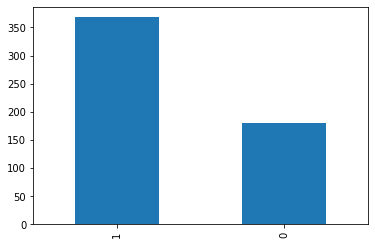

In [13]:
df['label'].value_counts().plot(kind='bar')

In [14]:
type(df.data[0])

numpy.ndarray

## resampling function

In [15]:
from sklearn.utils import resample
#up sampling the miniority class of dataset
df_majority = df[df.label==1]
df_minority = df[df.label==0]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples= 368,    # to match majority class
                                 random_state=123) # reproducible results
df_new = pd.concat([df_majority, df_minority_upsampled], ignore_index= True)
df_new.label.value_counts()

1    368
0    368
Name: label, dtype: int64

In [16]:
print(df.data[0].shape)

(15, 30000)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
import json
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split

#Model function
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
from sklearn.model_selection import train_test_split
import pywt
import datetime

from wfdb import io, plot
import wfdb
import os
import gc
from tqdm import tqdm_notebook as tqdm
#%matplotlib notebook
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import time
import keras
from keras.optimizers import RMSprop, Adam
import pywt
from sklearn.model_selection import train_test_split

# **CNN**

In [18]:
X = np.array(df_new['data'].tolist())
X.shape

(736, 15, 30000)

In [19]:
y = to_categorical(df_new['label'],2)

In [20]:
y.shape

(736, 2)

In [21]:
#split the train, test data from x,y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)#try stratify
#split the valid data from train data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [22]:
X_train.shape

(441, 15, 30000)

In [23]:
X_val.shape

(147, 15, 30000)

In [24]:
X_test.shape

(148, 15, 30000)

In [25]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [26]:
# def make_whole_set(df_data, channels, label_map, record_id,window_size):
#     n_windows = df_data.shape[0]
    
#     min_length = df_data['signal_length'].min()

#     if window_size is None:
#       window_size = min_length

#     dataX = np.zeros((n_windows, len(channels), window_size))
#     dataY = np.zeros((n_windows, len(label_map)))
    
#     record_list = []
    
#     nth_window = 0
#     for i, (patient, record) in enumerate(tqdm(df_data.iterrows())):
#         # read the record, get the signal data and transpose it
#         signal_data = io.rdrecord(os.path.join(data_path, record['name'])).p_signal[0:window_size].transpose()
       
#         dataX[i] = np.array(signal_data)
#         dataY[i][label_map[record.label]] = 1
        
        
#         if record_id:
#             record_list = [record['name']]
        
#     return dataX, dataY, record_list,window_size




In [27]:
# trainX, trainY, _,window_size = make_whole_set(df_train_patients, channels, label_map, False, None)

# testX, testY, record_list,_ = make_whole_set(df_test_patients, channels, label_map, True, window_size)
# # window_size = 1024
# # trainX, trainY, _ = make_set(df_train_patients, channels, label_map, False, window_size)
# # testX, testY, record_list = make_set(df_test_patients, channels, label_map, True,window_size)

# #split validation set
# testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.25, random_state=1)

#Shuffle order of train set
trainX, trainY = shuffle(X_train, y_train)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

In [28]:
trainX.shape

(441, 15, 30000)

In [29]:
#shape:(100, 15, 32000)
def buildModel_CNN():

    newModel = tf.keras.models.Sequential([
                                           
        tf.keras.layers.InputLayer(input_shape=(15,30000)),

        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
       
        tf.keras.layers.AvgPool1D(pool_size=1, strides=4, padding='SAME'),
        
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        
        tf.keras.layers.AvgPool1D(pool_size=1, strides=4, padding='SAME'),
       
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='elu'),
       
        tf.keras.layers.AvgPool1D(pool_size=1, strides=8, padding='SAME'),
       
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
       
        tf.keras.layers.Flatten(),
       
        tf.keras.layers.Dense(128, activation='relu'),
       
        tf.keras.layers.Dropout(rate=0.2),
       
        tf.keras.layers.Dense(2, activation='softmax')
    ])

    return newModel

In [30]:
model_test_CNN2 = buildModel_CNN()

In [31]:
model_test_CNN2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15, 4)             2520004   
_________________________________________________________________
average_pooling1d (AveragePo (None, 4, 4)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 16)             1488      
_________________________________________________________________
average_pooling1d_1 (Average (None, 1, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 32)             12832     
_________________________________________________________________
average_pooling1d_2 (Average (None, 1, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             5

In [32]:
X_val.shape

(147, 15, 30000)

In [33]:
import datetime
import tensorboard
%load_ext tensorboard
model_test_CNN2.compile(optimizer = 'adam', 
                  loss = "binary_crossentropy", metrics=["accuracy"])

log_dir = "logs/fit_CNN2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

model_test_CNN2.fit(trainX, trainY, validation_data=(X_val, y_val),validation_batch_size = 4, epochs=250,
                    batch_size=4 )

Epoch 1/250
111/111 [==============================] - 7s 23ms/step - loss: 0.7052 - accuracy: 0.5126 - val_loss: 0.6826 - val_accuracy: 0.6054
Epoch 2/250
111/111 [==============================] - 1s 12ms/step - loss: 0.6560 - accuracy: 0.6156 - val_loss: 0.6553 - val_accuracy: 0.6327
Epoch 3/250
111/111 [==============================] - 1s 12ms/step - loss: 0.6375 - accuracy: 0.6258 - val_loss: 0.6928 - val_accuracy: 0.6463
Epoch 4/250
111/111 [==============================] - 1s 12ms/step - loss: 0.6284 - accuracy: 0.6623 - val_loss: 0.5922 - val_accuracy: 0.7007
Epoch 5/250
111/111 [==============================] - 1s 12ms/step - loss: 0.5213 - accuracy: 0.7514 - val_loss: 0.6218 - val_accuracy: 0.6531
Epoch 6/250
111/111 [==============================] - 1s 12ms/step - loss: 0.5185 - accuracy: 0.7618 - val_loss: 0.7918 - val_accuracy: 0.6395
Epoch 7/250
111/111 [==============================] - 1s 12ms/step - loss: 0.4884 - accuracy: 0.7842 - val_loss: 0.6312 - val_accuracy:

In [34]:
output = model_test_CNN2.predict(X_test)
output_ = np.argmax(output,axis=1)
y_pred = output_
y_true = y_test.argmax(axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83        73
           1       0.85      0.81      0.83        75

    accuracy                           0.83       148
   macro avg       0.83      0.83      0.83       148
weighted avg       0.83      0.83      0.83       148



# **LSTM**

In [35]:
def make_model_lstm(input_shape, output_dim, lstm_layer, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(lstm_layer(256, return_sequences=True, input_shape=input_shape, batch_size=None))
    model.add(Dropout(dropout))
    model.add(lstm_layer(128, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy',metrics=[tf.keras.metrics.BinaryAccuracy()] , optimizer='adam')
    
    return model

#shape:(3774, 15, 1024)

df_new.shape

(736, 2)

## wave_slicing

In [36]:
import pandas as pd
import pywt
import matplotlib.pyplot as plt
convert_label = {' Myocardial infarction':0, ' Healthy control':1}


def wave_slicing_lstm(sig_data, window_size):
    slice_size = window_size
    data_length = sig_data.shape[0]
    sig_data = denoise(sig_data[0:data_length])
    #print('sig_data shape',sig_data.shape)
    #print('window_size',window_size)
    #print(sig_data)
    record_sliced = []
    try:
      n_windows = data_length//window_size -1 
      for i in range(n_windows): 
        tem_data = sig_data [i *slice_size : (i+1) *slice_size ]
        record_sliced.append(tem_data)
      #plot sample  
      #plt.plot(record_sliced[-1]) 
      #plt.show()

    except Exception as e:
      print('error:', e)

     #print(' record_sliced length:',len(record_sliced))   
    return record_sliced


def make_dataset_lstm(df_new, window_size):
  labels=[]
  record_sliced_list = []
  n_channels = len(df_new.data[0])
  for index in df_new.index:
    #print(index)
    label = df_new['label'][index]  

    signals_array = df_new['data'][index] 
    #print(signals_array.shape)
    is_first = True
    for i in range(len(signals_array)):
      sig_data = signals_array [i]
      #print(record.record_name+'_'+str(i)+' sig_data shape:', sig_data.shape)
      record_sliced = wave_slicing_lstm(sig_data, window_size)
      #print( record.record_name+'_'+str(i)+' record_sliced length:',len(record_sliced))
      for slice in record_sliced:
        record_sliced_list.append(slice)
        if is_first:   
          labels.append(label)
      is_first = False
  #print(len(record_sliced_list))
  record_sliced_list = np.array(record_sliced_list).reshape(-1, n_channels, window_size)
  labels = to_categorical(labels,2)
  return record_sliced_list, labels

X,y = make_dataset_lstm(df_new, window_size=1024)

#record0_sliced = wave_slicing_lstm(label_records[0].p_signal.T[0], window_size = 1000)

In [37]:
X.shape

(20608, 15, 1024)

In [38]:
y.shape

(20608, 2)

In [39]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [40]:
#split validated train and test set
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)

#split validation set
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.25, random_state=1)

#Shuffle order of train set
trainX, trainY = shuffle(trainX, trainY)

#Since we have a large class inbalance we need to udjust the weights for it.
fractions = 1-trainY.sum(axis=0)/len(trainY)
weights = fractions[trainY.argmax(axis=1)]

In [41]:
trainX.shape

(16486, 15, 1024)

In [42]:

%load_ext tensorboard
model_Path = '/gdrive/My Drive/model_output'

filepath = os.path.join(model_Path, "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'two_classes'
model_folder = os.path.join(model_Path,'tensorlogs/'+ model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))
    
tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
time_callback = TimeHistory()
callbacks = [checkpoint, tensorboard_callback, time_callback]

model = make_model_lstm((trainX.shape[1], trainX.shape[2]), trainY.shape[-1], LSTM)

model.fit(trainX, trainY, validation_data = (valX,valY), epochs=100, batch_size=256,sample_weight=weights, callbacks=callbacks)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
model dim:  (15, 1024) 2
Epoch 1/100
65/65 [==============================] - 5s 32ms/step - loss: 0.3432 - binary_accuracy: 0.5629 - val_loss: 0.6711 - val_binary_accuracy: 0.5820

Epoch 00001: loss improved from inf to 0.33799, saving model to /gdrive/My Drive/model_output/weights-improvement-01-bigger.hdf5
Epoch 2/100
65/65 [==============================] - 1s 17ms/step - loss: 0.3281 - binary_accuracy: 0.5994 - val_loss: 0.6402 - val_binary_accuracy: 0.6237

Epoch 00002: loss improved from 0.33799 to 0.32478, saving model to /gdrive/My Drive/model_output/weights-improvement-02-bigger.hdf5
Epoch 3/100
65/65 [==============================] - 1s 19ms/step - loss: 0.3157 - binary_accuracy: 0.6298 - val_loss: 0.6229 - val_binary_accuracy: 0.6479

Epoch 00003: loss improved from 0.32478 to 0.31182, saving model to /gdrive/My Drive/model_output/weights-improvement-03-bigger.hdf5
Epoch 4/100
65/65 [

In [43]:
output = model.predict(testX)
output_ = np.argmax(output,axis=1)
y_pred = output_
y_true = testY.argmax(axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1519
           1       0.87      0.87      0.87      1572

    accuracy                           0.87      3091
   macro avg       0.87      0.87      0.87      3091
weighted avg       0.87      0.87      0.87      3091



#CNN+LSTM

In [44]:
import keras
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
from keras.layers import *
from keras.models import *
from keras.objectives import *

time_step = 1024
num_sensors = 15
num_classes = 2
Batch_size = 32
num_epoch = 300

def conv_block_type1(x,num_filters, kernel_size):
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x


def conv_block_type2(x,num_filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x


def build_model(time_step,num_sensors, num_classes):
    input_shape = (time_step,num_sensors)

    #CNNModel
    inpt = keras.layers.Input(input_shape)

    x = Conv1D(32, 16, activation='relu')(inpt)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = conv_block_type1(x, 32, 16)

    x = conv_block_type2(x, 32, 16)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 128, 4)
    x = conv_block_type2(x, 128, 4)

    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(32, activation='relu', input_shape=(None, 128))(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inpt, outputs=x)

    return(model)

In [45]:
model_test3 = build_model(time_step,num_sensors,2)
model_test3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 15)]        0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1009, 32)          7712      
_________________________________________________________________
batch_normalization (BatchNo (None, 1009, 32)          128       
_________________________________________________________________
re_lu (ReLU)                 (None, 1009, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1009, 32)          16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1009, 32)          128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1009, 32)          0     

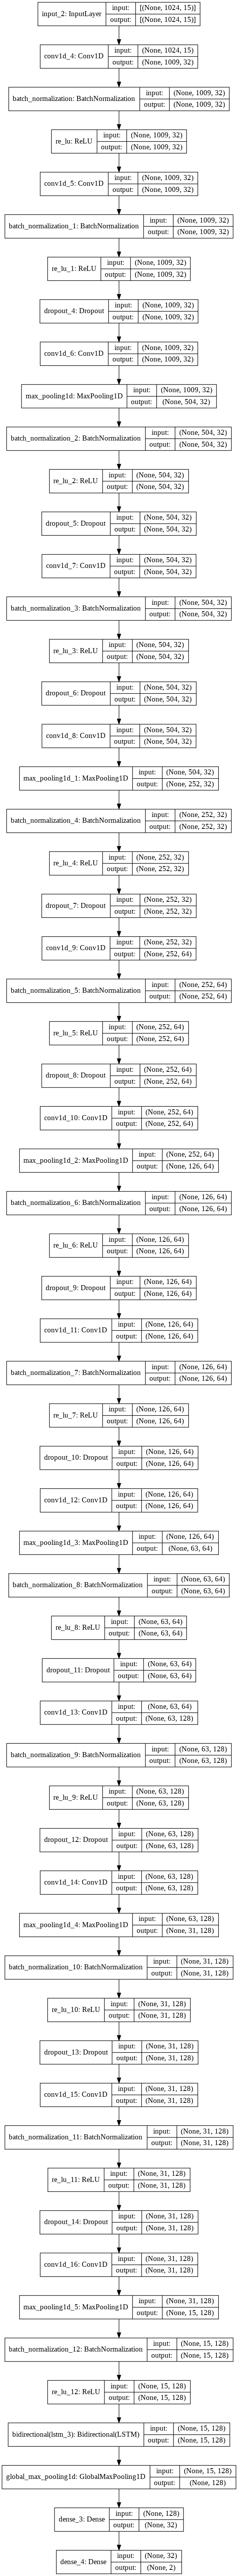

In [49]:
from keras.utils.vis_utils import plot_model
plot_model(model_test3, to_file='/content/gdrive/My Drive/physionet.org/model3_plot.png', show_shapes=True, show_layer_names=True)

In [67]:
 %load_ext tensorboard
model_Path = '/gdrive/My Drive/model_output'

filepath = os.path.join(model_Path, "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'two_classes'
model_folder = os.path.join(model_Path,'tensorlogs/'+ model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))
    
tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
time_callback = TimeHistory()
callbacks = [checkpoint, tensorboard_callback]
model_test3.compile(optimizer = 'adam' , 
                  loss = "binary_crossentropy", metrics=["binary_accuracy"])


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [58]:
def reshape_for_CNN_plus_LSTM(data):
  return data.transpose((0,2,1))


In [64]:
trainX = reshape_for_CNN_plus_LSTM(trainX)
valX = reshape_for_CNN_plus_LSTM(valX)
testX = reshape_for_CNN_plus_LSTM(testX)

In [71]:
valX.shape

(1031, 1024, 15)

In [ ]:
model_test3.fit(trainX, trainY,validation_data=(valX, valY), epochs=150, 
                batch_size=256,sample_weight=weights, callbacks=callbacks)

Epoch 1/150
65/65 [==============================] - 5s 80ms/step - loss: 0.2723 - binary_accuracy: 0.7119 - val_loss: 0.6526 - val_binary_accuracy: 0.5810

Epoch 00001: loss improved from 0.27390 to 0.27232, saving model to /gdrive/My Drive/model_output/weights-improvement-01-bigger.hdf5
Epoch 2/150
65/65 [==============================] - 5s 74ms/step - loss: 0.2739 - binary_accuracy: 0.7006 - val_loss: 0.6353 - val_binary_accuracy: 0.6101

Epoch 00002: loss did not improve from 0.27232
Epoch 3/150
65/65 [==============================] - 5s 74ms/step - loss: 0.2728 - binary_accuracy: 0.7059 - val_loss: 0.6338 - val_binary_accuracy: 0.6101

Epoch 00003: loss did not improve from 0.27232
Epoch 4/150
65/65 [==============================] - 5s 74ms/step - loss: 0.2733 - binary_accuracy: 0.7041 - val_loss: 0.6396 - val_binary_accuracy: 0.6052

Epoch 00004: loss did not improve from 0.27232
Epoch 5/150
65/65 [==============================] - 5s 74ms/step - loss: 0.2727 - binary_accuracy

In [ ]:
output = model_test3.predict(testX)
output_ = np.argmax(output,axis=1)
y_pred = output_
y_true = testY.argmax(axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))